# CH10 Deep learning for timeseries

機器學習範例 - 時間序列<br>
了解RNN<br>
應用RNNs在溫度預測<br>
進階RNN使用模式<br>

分類 - 為時間序列分配一個或多個分類標籤。例如，給定網站訪問者活動的時間序列，分類訪問者是機器人還是人類。<br>

事件檢測——識別連續數據流中特定預期事件的發生。一個特別有用的應用程序是“熱詞檢測”，其中模型監視音頻流並檢測諸如“Ok Google”或“Hey Alexa”之類的話語。<br>

異常檢測——檢測連續數據流中發生的任何異常情況。 您公司網絡上的異常活動？ 可能是襲擊者。 生產線上的異常讀數？ 是時候讓人類去看看了。 異常檢測通常是通過無監督學習完成的，因為您通常不知道要尋找哪種異常，因此您無法訓練特定的異常示例。<br>

在處理時間序列時，您會遇到範圍廣泛的特定於領域的數據表示技術。 例如，您可能已經聽說過傅里葉變換(Fourier Transform)，它包括根據不同頻率的波的疊加來表達一系列值。 <br>
在預處理任何主要以周期和振盪為特徵的數據（如聲音、摩天大樓框架的振動或您的腦電波）時，傅里葉變換可能非常有價值。 <br>
在深度學習的背景下，傅立葉分析（或相關的梅爾頻率分析）和其他特定領域的表示可以用作特徵工程的一種形式，一種在訓練模型之前準備數據的方法，以完成工作，模型更容易。 <br>
但是，我們不會在這些頁面中介紹這些技術； 相反，我們將專注於建模部分。<br>
在本章中，您將了解遞歸神經網絡 (RNN) 以及如何將它們應用於時間序列預測<br>

# 10.2 A temperature-forecasting example

接下來，我們來嘗試對溫度的時間序列進行預測。<br>
但你會發現densely connected networks 和 CNN 並不能很好地處理。<br>
所以在這裡，我們使用RNNs(recurrent neural networks)。

我們將使用德國耶拿馬克斯普朗克生物地球化學研究所氣象站記錄的天氣時間序列數據集。<br>
1 在這個數據集中，14 個不同的量（例如溫度、壓力、濕度、風向等）在幾年內每 10 分鐘記錄一次。 原始數據可追溯到 2003 年，但我們將下載的數據子集僅限於 2009-2016 年。

https://www.bgc-jena.mpg.de/wetter/

In [4]:
#安裝並解壓縮
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-29 03:02:34--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.204.88, 52.216.186.69, 52.216.36.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.204.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.17MB/s    in 2.5s    

2022-11-29 03:02:37 (5.17 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


# Listing 10.1 檢查耶拿天氣數據集的數據

In [5]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


內容包含420,551行data，包括時間和14個天氣相關數值

# Listing 10.2 Parsing the data解析數據

In [6]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

接下來，我們將數據進行畫圖，方便我們預測溫度-資料將跨越8年

# Listing 10.3 Plotting the temperature timeseries

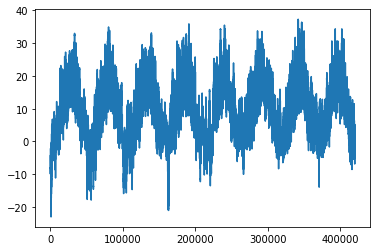

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

接下來，畫出前10天的資料，因為資料是每10分鐘一筆，所以總共有24*6*10(天)=1440筆。

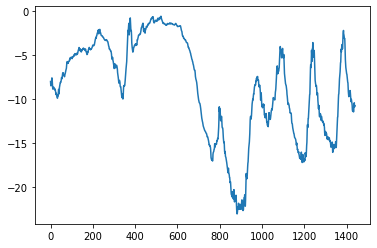

In [8]:
plt.plot(range(1440), temperature[:1440])

始終在數據中尋找周期性

多個時間尺度上的周期性是時間序列數據的一個重要且非常常見的屬性。 無論您是在查看天氣、商場停車場佔用率、網站流量、雜貨店銷售額，還是健身追踪器中記錄的步數，您都會看到日週期和年周期（人為生成的數據也往往具有特徵 每週循環）。 在探索數據時，請務必尋找這些模式。

使用我們的數據集，如果您試圖根據過去幾個月的數據預測下個月的平均溫度，由於數據的可靠的年尺度週期性，問題會很容易<br>
但是看天數範圍內的數據，溫度看起來要混亂得多。<br>
這個時間序列在日尺度上是可預測的嗎？<br>
讓我們找出答案。<br>

在我們所有的實驗中，我們將使用前 50% 的數據進行訓練，接下來的 25% 用於驗證，最後 25% 用於測試。<br>
在處理時間序列數據時，使用比訓練數據更新的驗證和測試數據很重要，因為您試圖根據過去預測未來，而不是相反，並且您的驗證/測試拆分應該反映這一點。 如果將時間軸倒轉，有些問題恰好會簡單得多！<br>

# 清單 10.5 計算我們將用於每個數據拆分的樣本數

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


# 10.2.1 準備資料

問題的具體表述如下：給定前五天的數據，每小時採樣一次，我們能否預測 24 小時內的溫度？<br>
首先，讓我們將數據預處理為神經網絡可以攝取的格式。這很簡單：數據已經是數字，所以你不需要做任何向量化。但是數據中的每個時間序列都在不同的範圍內（例如，以毫巴為單位測量的大氣壓約為 1,000，而以毫摩爾每摩爾測量的 H2OC 約為 3）。 我們將獨立地標準化每個時間序列，以便它們都在相似的範圍內取小值。 我們將使用前 210,225 個時間步長作為訓練數據，因此我們將僅計算這部分數據的均值和標準差。

# 清單 10.6 規範化數據

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

接下來，讓我們創建一個數據集對象，該對像生成過去五天的數據批次以及未來 24 小時的目標溫度。 因為數據集中的樣本是高度冗餘的（樣本 N 和样本 N + 1 的大部分時間步長是相同的），顯式地為每個樣本分配內存是一種浪費。 相反，我們將動態生成樣本，同時僅在內存中保留原始 raw_data 和溫度數組，僅此而已。
我們可以很容易地編寫一個 Python 生成器來執行此操作，但是 Keras 中有一個內置的數據集實用程序可以執行此操作，所以我們可以通過使用它來節省一些工作。 您通常可以將它用於任何類型的時間序列預測任務。

# 了解 TIMESERIES_DATASET_FROM_ARRAY()


要了解 timeseries_dataset_from_array() 的作用，讓我們看一個簡單的例子。 一般的想法是您提供一個時間序列數據數組（數據參數），timeseries_dataset_from_array() 為您提供從原始時間序列中提取的窗口（我們稱它們為“序列”）

您還可以將目標參數（數組）傳遞timeseries_dataset_from_array() 。目標數組的第一個條目應該與將從數據數組生成的第一個序列的所需目標相匹配。<br>
因此，如果您正在進行時間序列預測，則目標應該與數據是相同的數組，但有一定的偏移量。<br>
例如，使用 data = [0 1 2 3 4 5 6 ...] 和 sequence_length=3 ，您可以通過傳遞 targets = [3 4 5 6 ...] 創建一個數據集來預測系列中的下一步。 讓我們試試看：<br>

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


我們將使用timeseries_dataset_from_array（）<br>實例化三個數据集：一個用於訓練，一個用於驗證，一個用來測試。<br>
我們將使用以下參數值：sampling_rate=6-觀測值將每小時採樣一個數據點：我們將只保留一個數據<br>


我們將使用timeseries_dataset_from_array（）<br>
實例化三個數据集：一個用於訓練，一個用於驗證，一個用來測試。<br>
我們將使用以下參數值：sampling_rate=6-觀測值將每小時採樣一個數據點：我們將只保留一個超出6的數據。
sequence_length=120-觀測將回溯5天（120小時）。
delay=sampling_rate*（sequence_length+24-1）-序列的目標是序列結束後24小時的溫度。
製作訓練數据集時，我們將跳過start_index=0和end_index=num_train_samples，只使用前50%的數據。對於驗證數据集，我們將跳過start_index=num_train_samples和end_index=num_train_samples+num_val_samples以使用接下來的25%數據。最後，對於測試數据集，我們將傳遞start_index=num_train_samples+num_val_samples以使用剩餘的樣本。

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


每個數据集生成一個元組（樣本、目標），其中樣本是一批256個樣本，每個樣本包含120個連續小時的輸入數據，目標是256個目標溫度的對應數組。<br>
注意，樣本是隨機混洗的，囙此一批中的兩個連續序列（如樣本[0]和樣本[1]）在時間上不一定接近。

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


#10.2.2常識，非機器學習基線
在我們開始使用黑盒深度學習模型來解决溫度預測問題之前，讓我們嘗試一種簡單、常識的方法。 它將作為一個健全的檢查，它將建立一個我們必須超越的基線，以證明更先進的機器學習模型的有效性。 當您正在處理一個尚未找到解決方案的新問題時，使用常識基線可能會很有用。 一個典型的例子是不平衡分類任務，有些類比其他類更常見。 如果您的數據包含90%的A類實例和10%的B類實例，那麼分類任務的一種常見方法是在呈現新樣本時始終預測“A”。 這樣的分類總體上準確率為90%，囙此任何基於學習的方法都應該超過這90%的分數，以證明其有用性。 有時，這種基本的不可避免的事實令人驚訝地難以擊敗。


在這種情況下，可以安全地假設溫度時間序列是連續的（明天的溫度可能接近今天的溫度），並且是週期性的。 囙此，一個常識性的方法是總是預測從現在起24小時的溫度將等於現在的溫度。 讓我們使用平均絕對誤差（MAE）度量來評估該方法，定義如下：

np.mean(np.abs(preds-targets))


這是評估迴圈。

Computing the common-sense baseline MAE

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62



該常識基線實現了2.44攝氏度的驗證MAE和2.62攝氏度的測試MAE。 囙此，如果你總是假設未來24小時的氣溫將與現在一樣，那麼你的平均氣溫將下降2.5度。 這還不算太糟，但你可能不會基於這種啟發式方法推出天氣預報服務。 現在的遊戲是利用你的深度學習知識做得更好。

# 10.2.3 Let’s try a basic machine learning model

就像在嘗試機器學習方法之前建立一條共同的感覺線是有用的一樣，在研究諸如RNN之類複雜且計算昂貴的模型之前，先建立簡單、廉價的機器學習模型（例如小型、密集連接的網絡）也是有用的。這是確保解决問題的任何進一步複雜性都是合法的並帶來真正好處的最佳方法。
下麵的清單顯示了一個完全連接的模型，它首先對數據進行加密，然後在兩個密集層中運行。注意最後一個密集層上缺少啟動函數，這對於回歸問題來說是典型的。我們使用均方誤差（MSE）作為損失，而不是MAE，因為與MAE不同，它在零附近是平滑的，這對於梯度下降是有用的特性。我們將通過在compile（）中添加MAE作為度量來監控MAE。

Listing 10.10 Training and evaluating a densely connectedmodel

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 43s 50ms/step - loss: 12.6530 - mae: 2.7456 - val_loss: 10.0992 - val_mae: 2.5048
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 8.8989 - mae: 2.3478 - val_loss: 13.3409 - val_mae: 2.8810
Epoch 3/10
819/819 [==============================] - 39s 48ms/step - loss: 8.1599 - mae: 2.2515 - val_loss: 10.9004 - val_mae: 2.6145
Epoch 4/10
819/819 [==============================] - 39s 48ms/step - loss: 7.7092 - mae: 2.1903 - val_loss: 10.1305 - val_mae: 2.5170
Epoch 5/10
819/819 [==============================] - 40s 48ms/step - loss: 7.3833 - mae: 2.1429 - val_loss: 10.3820 - val_mae: 2.5548
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 7.1240 - mae: 2.1064 - val_loss: 11.7249 - val_mae: 2.7120
Epoch 7/10
819/819 [==============================] - 39s 47ms/step - loss: 6.9865 - mae: 2.0870 - val_loss: 11.1665 - val_mae: 2.6568
Epoch 8/10
819/819 [==============================] - 

讓我們顯示驗證和培訓的損失曲線（見圖10.3）。

Listing 10.11 Plotting results

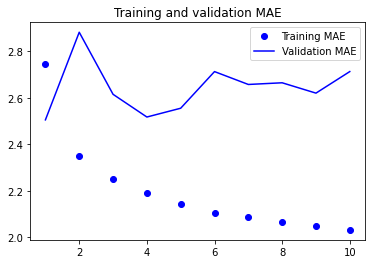

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

一些驗證損失接近無學習基線，但並不可靠。 這從一開始就表明了擁有這一底線的好處：要想取得優異成績並不容易。 你的常識包含了很多機器學習模型無法獲取的寶貴資訊。

你可能會想，如果存在一個簡單的、性能良好的模型來從數據到目標（常識基線），為什麼你正在訓練的模型不找到它並改進它？好吧，你在其中尋找解決方案的模型空間，也就是說，你的假設空間是所有可能的兩層結構的空間，具有你定義的配寘。常見的感覺主義只是數百萬個模型中的一個，可以在這個空間中表示。這就像大海撈針。僅僅因為你的假設太空科技上存在一個好的解決方案，並不意味著你能够通過梯度下降找到它。
這是機器學習的一個非常顯著的局限性：除非學習算灋被硬編碼以尋找特定的簡單模型，否則它有時無法找到簡單問題的簡單解決方案。這就是為什麼利用良好的特性工程和相關的架構優先順序是至關重要的：您需要準確地告訴您的模型它應該尋找什麼。

10.2.4 Let’s try a 1D convolutional model

說到利用正確的架構優先順序，由於我們的輸入序列具有日常週期，也許卷積模型可以起作用。時間對流可以在不同的日子重用相同的表示，就像空間對流可以在動畫中的不同位置重用相同的表達一樣。
您已經瞭解了Conv2D和SeparableConv2D層，它們通過在2D網格上滑動的小視窗查看輸入。這些層也有1D甚至3D版本：Conv1D、SeparableConv1D和Conv3D。
2 Conv1D層依賴於在輸入序列上滑動的1D視窗，而Conv3D層依賴於可在輸入體積上滑動的立方體視窗。
2請注意，沒有SeparableConv3D層，這不是出於任何理論原因，只是因為我沒有實現它。
囙此，您可以構建1D對流，嚴格類似於2D對流。對於遵循翻譯不變性假設的任何序列數據，它們都是一個很好的篩檢程式（這意味著如果您滑動視窗的內容應遵循相同的内容，而與視窗的位置無關）。
讓我們嘗試一下我們的溫度預測問題。我們將選擇初始視窗長度24，這樣我們一次可以查看24小時的數據（一個週期）。當我們對序列進行下採樣（通過MaxPooling1D層）時，我們將相應地减小視窗大小：

Let's try a 1D convolutional model

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 54s 58ms/step - loss: 21.4335 - mae: 3.6461 - val_loss: 15.6309 - val_mae: 3.1319
Epoch 2/10
819/819 [==============================] - 45s 54ms/step - loss: 15.4609 - mae: 3.1255 - val_loss: 15.7132 - val_mae: 3.1256
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 14.2802 - mae: 2.9972 - val_loss: 15.0898 - val_mae: 3.0877
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 13.5908 - mae: 2.9222 - val_loss: 17.0226 - val_mae: 3.2827
Epoch 5/10
819/819 [==============================] - 44s 53ms/step - loss: 13.0219 - mae: 2.8559 - val_loss: 15.8674 - val_mae: 3.1580
Epoch 6/10
819/819 [==============================] - 44s 54ms/step - loss: 12.5194 - mae: 2.7990 - val_loss: 14.9550 - val_mae: 3.0534
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 12.0347 - mae: 2.7438 - val_loss: 17.8941 - val_mae: 3.3632
Epoch 8/10
819/819 [============================

結果表明，該模型的效能甚至比密集連接模型更差，僅實現了約2.9度的驗證MAE，與常識基線相去甚遠。<br>
這裡出了什麼問題？<br>
兩件事：第一，天氣數據不太符合平移方差假設。<br>
雖然數據每天都有特點週期，早上的數據與晚上或半夜的數據具有不同的内容。天氣數據僅在特定時間尺度上是平移不變的。<br>
第二，在我們的數據中排序——很多。最近的數據比五天前的數據更能預測第二天的氣溫。一維對流網絡無法利用這一事實。特別是，我們的最大池和全域平均池層在很大程度上破壞了訂單資訊。<br>

10.2.5 A fi rst recurrent baseline


無論是完全連接方法還是卷積方法都做得很好，但這並不意味著機器學習不適用於這個問題。 密集連接的方法首先對時間序列進行了細化，從而從輸入數據中去除了時間的概念。 卷積方法以相同的管道處理數據的每個片段，甚至應用池，這會破壞順序資訊。 讓我們來看看數據是什麼：一個序列，其中因果關係和順序很重要。


有一系列專門為這個用例設計的神經網路架構：遞迴神經網路。 其中，長期短期記憶（LSTM）層一直很受歡迎。 我們將在一分鐘內看到這些模型是如何工作的，但讓我們先嘗試一下LSTM層。

Listing 10.12 A simple LSTM-based model

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 52s 60ms/step - loss: 45.1882 - mae: 4.9110 - val_loss: 13.5515 - val_mae: 2.7850
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 11.0035 - mae: 2.5809 - val_loss: 10.6301 - val_mae: 2.5166
Epoch 3/10
819/819 [==============================] - 52s 63ms/step - loss: 9.5808 - mae: 2.4200 - val_loss: 10.4707 - val_mae: 2.4964
Epoch 4/10
819/819 [==============================] - 52s 64ms/step - loss: 9.1853 - mae: 2.3639 - val_loss: 10.2397 - val_mae: 2.4827
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 8.9239 - mae: 2.3266 - val_loss: 10.3742 - val_mae: 2.4916
Epoch 6/10
819/819 [==============================] - 48s 57ms/step - loss: 8.6868 - mae: 2.2965 - val_loss: 10.7641 - val_mae: 2.5288
Epoch 7/10
819/819 [==============================] - 44s 54ms/step - loss: 8.5139 - mae: 2.2756 - val_loss: 10.5630 - val_mae: 2.5175
Epoch 8/10
819/819 [==============================] -

圖10.5顯示了結果。 好多了！ 我們實現了低至2.36度的驗證MAE和2.55度的測試MAE。 基於LSTM的模型最終可以超越常識基線（儘管現時只是一點點），證明了機器學習在這項任務上的價值。

Figure 10.5 Training and validation MAE on the Jenatemperature-forecasting task with an LSTM-based model(note that we omit epoch 1 on this graph, because the hightraining MAE (7.75) at epoch 1 would distort the scale)


但是，為什麼LSTM模型的效能明顯優於完全連接的模型或對流模型？ 我們如何進一步改進模型？ 為了回答這個問題，讓我們更仔細地看看當前的神經網路。

# 10.3 Understanding recurrent neuralnetworks

到目前為止，你所見過的所有神經網絡（例如密集連接網絡和卷積神經網絡）的一個主要特徵是它們沒有記憶。<br>
向他們顯示的每個輸入都是獨立處理的，輸入之間不保留任何狀態。<br>
對於這樣的網絡，為了處理一個序列或一系列時間序列的數據點，您必須立即向網絡顯示整個序列：將其轉換為單個數據點。<br>
例如，這就是我們在密集連接網絡示例中所做的：我們將五天的數據扁平化為一個大向量並一次性處理它。<br>
這樣的網絡稱為前饋網絡(feedforward networks)。<br>
相比之下，當你閱讀當前句子時，你是在逐字逐句地處理它——或者更確切地說，逐眼掃視——同時保留對之前內容的記憶；<br>
這使您可以流暢地表達這句話所傳達的含義。<br>
生物智能以增量方式處理信息，同時維護其處理內容的內部模型，該模型基於的過去信息構建，並隨著新信息的出現不斷更新。<br>

循環神經網絡 (RNN) 採用相同的原理，儘管是極其簡化的版本：它通過遍歷序列元素來處理序列，並保持包含與其目前所見相關信息的狀態。<br>
實際上，RNN是一種具有內部循環的神經網絡（見圖 10.6）

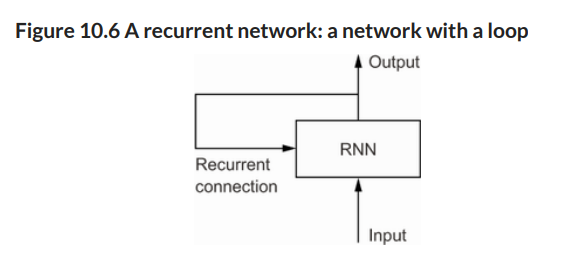

RNN 的狀態在處理兩個不同的獨立序列（例如一批中的兩個樣本）之間重置，因此您仍然將一個序列視為單個數據點：網絡的單個輸入。<br>
變化是這個數據點不再一步處理；<br>
相反，網絡在內部循環遍歷序列元素。<br>
為了弄清楚循環和狀態的這些概念，讓我們實現玩具 RNN 的前向傳遞。<br>
此 RNN 將一系列向量作為輸入，我們將其編碼為大小為 (timesteps,input_features) 的 rank-2 張量。<br>
它遍歷時間步長，在每個時間步長，它考慮其在 t 的當前狀態和 t 的輸入（形狀為 (input_features,) ，並將它們組合以獲得 t 的輸出。然後我們將為下一個設置狀態步驟成為之前的輸出。對於第一個時間步，之前的輸出未定義；因此，沒有當前狀態。因此我們將狀態初始化為全零向量，稱為網絡的初始狀態。<br>

在虛擬碼(偽代碼)中，這就是RNN

Listing 10.13 Pseudocode RNN

state_t = 0 <br>
for input_t in input_sequence: <br>
  output_t=f(input_t,state_t) <br>
  state_t = output_t <br>

您甚至可以充實函數 f：輸入和狀態到輸出的轉換將由兩個矩陣 W 和 U 以及偏置向量參數化。 它類似於前饋網絡中由密集連接層操作的轉換。

Listing 10.14 More-detailed pseudocode for the RNN

state_t = 0 <br>
for input_t in input_sequence: <br>
  output_t = activation(dot(W, input_t) + dot(U, state_t) + b) <br>
  state_t = output_t <br>

為了使這些概念絕對明確，讓我們編寫一個簡單 RNN 前向傳遞的簡單 NumPy 實現。

Listing 10.15 NumPy implementation of a simple RNN

In [3]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

這很容易。<br>
總之，RNN 是一個 for 循環，它重用在循環的前一次迭代中計算的數量，僅此而已。<br>

當然，您可以構建許多符合此定義的不同 RNN——此示例是最簡單的 RNN 公式之一。 RNN 的特徵在於它們的階躍函數，例如本例中的以下函數（見圖 10.7）。<br>

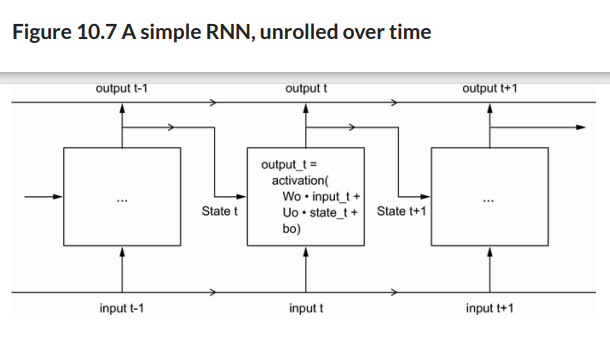

# NOTE

在此示例中，最終輸出是形狀為 (timesteps, output_features) 的 2 階張量，其中每個時間步都是循環在時間 t 的輸出。<br>
輸出張量中的每個時間步 t 都包含有關輸入序列中時間步 0 到 t 的信息——關於整個過去。 出於這個原因，在許多情況下，您不需要這個完整的輸出序列；<br>
您只需要最後一個輸出（循環末尾的 output_t），因為它已經包含有關整個序列的信息。<br>

# 10.3.1 A recurrentlayer in Keras

我們剛剛在 NumPy 中天真地實現的過程對應於一個實際的 Keras 層——SimpleRNN 層。<br>
有一個細微差別：SimpleRNN 處理一批序列，就像所有其他 Keras 層一樣，而不是 NumPy 示例中的單個序列。<br>
這意味著它接受形狀為 (batch_size, timesteps, input_features) 的輸入，而不是 (timesteps, input_features) 。 在指定初始 Input() 的形狀參數時，請注意您可以將時間步長條目設置為 None ，這使您的網絡能夠處理任意長度的序列。<br>

Listing 10.16 An RNN layer that can process sequences of any
length

In [4]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

NameError: ignored

如果您的模型旨在處理可變長度的序列，這將特別有用。<br>
然而，如果你所有的序列都具有相同的長度，我建議指定一個完整的輸入形狀，因為它使 model.summary() 能夠顯示輸出長度信息，這總是很好，並且它可以解鎖一些性能優化（見“ 關於 RNN 運行時性能的注意事項”（本章稍後的側邊欄）。<br>
Keras 中的所有循環層（ SimpleRNN 、 LSTM 和 GRU ）都可以在兩種不同的模式下運行：它們可以返回每個時間步的連續輸出的完整序列（形狀為 (batch_size, timesteps, output_features) 的 rank-3 張量）或僅返回每個輸入序列的最後一個輸出（形狀為 (batch_size, output_features) 的 rank-2 張量）。 這兩種模式由 return_sequences 構造函數參數控制。 讓我們看一個使用 SimpleRNN 並僅返回最後一個時間步的輸出的示例。<br>

Listing 10.17 An RNN layer that returns only its last output
step

In [5]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

NameError: ignored

以下示例返回完整的狀態序列。

Listing 10.18 An RNN layer that returns its full output
sequence

In [6]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

NameError: ignored

為了增加網絡的表徵能力，一個接一個地堆疊幾個循環層有時很有用。<br>
在這樣的設置中，您必須讓所有中間層返回完整的輸出序列。

In [7]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

NameError: ignored

實際上，您很少會使用 SimpleRNN 層。 它通常過於簡單而無法真正使用。<br>
特別是，SimpleRNN 有一個主要問題：雖然理論上它應該能夠在時間 t 保留關於之前看到的許多時間步長的輸入的信息，但這種長期依賴性在實踐中被證明是不可能學習的。<be>
這是由於梯度消失問題，這種效果類似於在多層深度的非循環網絡（前饋網絡）中觀察到的效果：隨著您不斷向網絡添加層，網絡最終變得無法訓練。 Hochreiter、Schmidhuber 和 Bengio 在 1990 年代初期研究了這種效應的理論原因。<be>
例如，參見 Yoshua Bengio、Patrice Simard 和 Paolo Frasconi，“使用梯度下降學習長期依賴關係很困難”，IEEE 神經網絡交易 5，第 2 (1994)。<br>
See, for example, Yoshua Bengio, Patrice Simard, and Paolo
Frasconi,
“Learning Long-Term Dependencies with Gradient
Descent Is Difficult,
” IEEE Transactions on Neural Networks 5, no. 2
(1994).<br>

值得慶幸的是，SimpleRNN 並不是 Keras 中唯一可用的循環層。 還有另外兩個，LSTM 和 GRU，旨在解決這些問題。<br>
讓我們考慮 LSTM 層。 底層的長短期記憶 (LSTM) 算法由 Hochreiter 和 Schmidhuber 於 1997 年開發； 4 這是他們對梯度消失問題研究的結晶。<br>
 Sepp Hochreiter and Jürgen Schmidhuber,
“Long Short-Term
Memory,
” Neural Computation 9, no. 8 (1997).<br>

該層是您已知的 SimpleRNN 層的變體； 它增加了一種跨多個時間步攜帶信息的方法。<br>
想像一條與您正在處理的序列平行運行的傳送帶。<br>
來自序列的信息可以隨時跳到傳送帶上，傳送到稍後的時間步長，並在需要時原封不動地跳下。<br>
這本質上就是 LSTM 所做的：它為以後保存信息，從而防止舊信號在處理過程中逐漸消失。<br>
這應該讓你想起你在第 9 章中學到的剩餘連接：它幾乎是相同的想法。<br>
為了詳細了解這個過程，讓我們從 SimpleRNN 單元開始（見圖 10.8）。<br>
因為您將有很多權重矩陣，所以在單元格中索引 W 和 U 矩陣，並使用字母 o（Wo 和 Uo）作為輸出。<br>

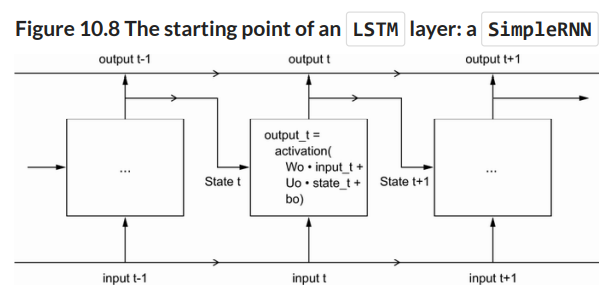

讓我們向這張圖片添加一個額外的數據流，該數據流攜帶跨時間步長的信息。 將其在不同時間步的值稱為 c_t ，其中 C 代表進位。 此信息將對單元格產生以下影響：它將與輸入連接和循環連接結合（通過密集變換：一個帶有權重矩陣的點積，然後是 52/80 偏置添加和應用激活 函數），它將影響發送到下一個時間步的狀態（通過激活函數和乘法運算）。 從概念上講，進位數據流是一種調製下一個輸出和下一個狀態的方法（見圖 10.9）。 到目前為止很簡單。

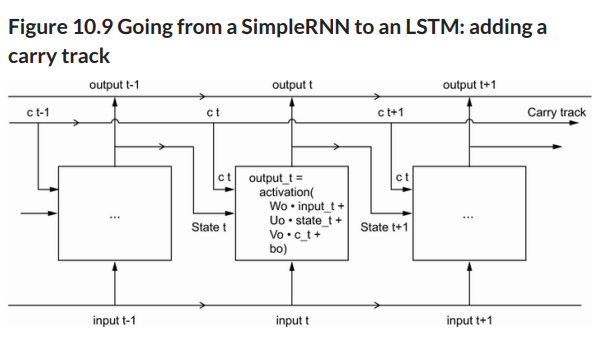

現在是微妙之處——計算進位數據流的下一個值的方式。 它涉及三個不同的轉換。 這三個都具有 SimpleRNN 單元格的形式：

In [23]:
y = activation(dot(state_t, U) + dot(input_t, W) + b)

但是所有三個轉換都有自己的權重矩陣，我們將用字母 i 、 f 和 k 對其進行索引。 這是我們目前所做的（它可能看起來有點武斷，但請耐心等待）。

Listing 10.20 Pseudocode details of the LSTM architecture
(1/2)


In [ ]:
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t))
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)


我們通過組合 i_t 、 f_t 和 k_t 獲得新的進位狀態（下一個 c_t ）。

Listing 10.21 Pseudocode details of the LSTM architecture
(2/2)


In [ ]:
c_t+1 = i_t * k_t + c_t * f_t

如圖 10.10 所示添加它，就是這樣。 沒那麼複雜——只是有點複雜。

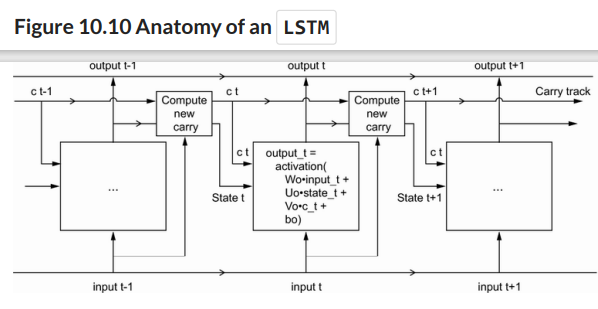

如果你想獲得哲學，你可以解釋這些操作中的每一個是做什麼的。<br>
例如，您可以說將 c_t 和 f_t 相乘是一種故意忘記進位數據流中不相關信息的方法。 同時，i_t 和 k_t 提供關於當前的信息，用新信息更新進位軌道。<br>
但歸根結底，這些解釋並沒有多大意義，因為這些操作實際上做了什麼是由參數化它們的權重的內容決定的；<br>
並且權重以端到端的方式學習，從每一輪訓練開始，因此不可能將這個或那個操作歸功於特定目的。<br>
RNN 單元的規範（如前所述）決定了你的假設空間——你將在訓練期間搜索良好模型配置的空間——但它並不能決定單元的作用；<br>
這取決於細胞重量。<br>
具有不同權重的同一個單元格可以做非常不同的事情。<br>
因此，構成 RNN 單元的操作組合更好地解釋為一組對搜索的約束，而不是工程意義上的設計。<br>
可以說，這種約束的選擇——如何實現 RNN 單元的問題——最好留給優化算法（如遺傳算法或強化學習過程）而不是人類工程師。<br>
將來，這就是我們構建模型的方式。<br>
總之：您不需要了解任何有關 LSTM 單元的特定架構的信息；<br>
作為一個人，理解它不應該是你的工作。<br>
請記住 LSTM 單元的用途：允許過去的信息在以後重新註入，從而解決梯度消失問題。<br>

# 10.4 Advanced use of recurrent neural networks

到目前為止，您已經了解了<br> RNN 是什麼以及它們如何工作<br> LSTM 是什麼，以及為什麼它在長序列上比原始 RNN 更有效<br> 如何使用 Keras RNN 層來處理序列數據<br> 接下來，我們將回顧一些更高級的 RNN 的特性，可以幫助您充分利用深度學習序列模型。<br>
到本節結束時，您將了解有關在 Keras 中使用循環網絡的大部分知識。

10.4.1 Using recurrent dropoutto fight overfitting

讓我們回到第 10.2.5 節中使用的基於 LSTM 的模型——我們的第一個模型能夠超越常識基線。<br>
如果您查看訓練和驗證曲線（圖 10.5），很明顯該模型很快就會過度擬合，儘管只有很少的單元：訓練和驗證損失在幾個時期後開始出現顯著差異。<br>
您已經熟悉了一種解決這種現象的經典技術：dropout，它隨機將層的輸入單元清零，以打破該層所暴露的訓練數據中的偶然相關性。<br>
但是如何在循環網絡中正確應用 dropout 並不是一個簡單的問題。<br>

人們早就知道，在循環層之前應用 dropout 會阻礙學習而不是幫助正則化。 2016 年，Yarin Gal，作為他關於貝葉斯深度學習的博士論文的一部分，5 確定了在循環網絡中使用 dropout 的正確方法：應該在每個時間步應用相同的 dropout mask（相同的丟棄單元模式），而不是 使用隨時間步長隨機變化的 dropout mask。 更重要的是，為了規範由 GRU 和 LSTM 等層的循環門形成的表示，應該將時間恆定的 dropout mask 應用於層的內部循環激活（循環 dropout 掩碼）。<br>
在每個時間步使用相同的 dropout mask 允許網絡通過時間正確地傳播它的學習錯誤； 臨時隨機丟失掩碼會破壞此錯誤信號並對學習過程有害。<br>

See Yarin Gal,
“Uncertainty in Deep Learning,
” PhD thesis
(2016), http://mng.bz/WBq1.<br>

Yarin Gal 使用 Keras 進行研究，並幫助將該機制直接構建到 Keras 循環層中。 Keras 中的每個循環層都有兩個與丟失相關的參數： dropout ，一個指定層輸入單元的丟失率的浮點數，以及 recurrent_dropout ，指定循環單元的丟失率。<br>
讓我們在第一個 LSTM 示例的 LSTM 層中添加循環丟失，看看這樣做如何影響過度擬合。<br>
多虧了 dropout，我們不需要那麼多地依賴網絡大小來進行正則化，所以我們將使用一個單元數翻倍的 LSTM 層，希望它應該更具表現力（如果沒有 dropout，這個網絡就會開始 馬上過擬合——試試吧）。<br>
因為使用 dropout 進行正則化的網絡總是需要更長的時間才能完全收斂，所以我們將訓練模型五倍的 epoch。<br>

Listing 10.22 Training and evaluating a dropout-regularized
LSTM

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

NameError: ignored

圖 10.11 顯示了結果。 成功！ 我們在前 20 個時期不再過度擬合。 我們實現了低至 2.27 度的驗證 MAE（比無學習基線提高 7%）和 2.45 度的測試 MAE（比基線提高 6.5%）。
還不錯。

RNN RUNTIME PERFORMANCE

參數非常少的循環模型，如本章中的模型，在多核 CPU 上往往要快得多 8 9 10 11 12 13 14 15 keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True) ] 模型。 compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks) copy  62/80 比在 GPU 上 ，因為它們只涉及小的矩陣乘法，並且由於 for 循環的存在，乘法鏈不能很好地並行化。 但更大的 RNN 可以極大地受益於 GPU 運行時。<br>
當在 GPU 上使用帶有默認關鍵字參數的 Keras LSTM 或 GRU 層時，您的層將利用 cuDNN 內核，這是一種高度優化的低級 NVIDIA 提供的底層算法實現（我在上一章中提到過這些）。 像往常一樣，cuDNN 內核是喜憂參半：它們速度快，但不靈活——如果您嘗試執行默認內核不支持的任何操作，您將遭受急劇減速，這或多或少迫使您堅持 NVIDIA 的做法 提供。 例如，LSTM 和 GRU cuDNN 內核不支持循環丟失，因此將它添加到您的層會強制運行時回退到常規 TensorFlow 實現，這在 GPU 上通常慢兩到五倍（即使它的計算 成本是一樣的）。<br>

作為在無法使用 cuDNN 時加速 RNN 層的一種方法，您可以嘗試展開它。 展開 for 循環包括刪除循環並簡單地將其內容內聯 N 次。<br>
對於 RNN 的 for 循環，展開可以幫助 TensorFlow 優化底層計算圖。
然而，它也會大大增加 RNN 的內存消耗——因此，它只適用於相對較小的序列（大約 100 步或更少）。 另外，請注意，只有當模型事先知道數據中的時間步數時，您才能執行此操作（也就是說，如果您將沒有任何 None 條目的形狀傳遞給初始 Input() ）。<br>
它是這樣工作的：<br>

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

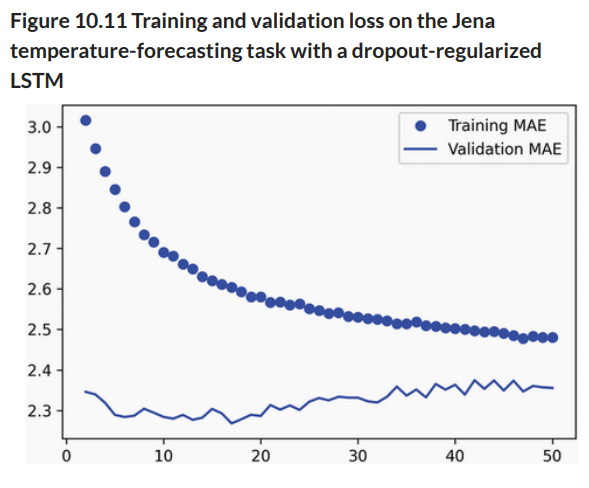

# 10.4.2 Stacking recurrentlayers

因為你不再過度擬合但似乎遇到了性能瓶頸，你應該考慮增加網絡的容量和表達能力。 回想一下通用機器學習工作流程的描述：增加模型的容量通常是個好主意，直​​到過度擬合成為主要障礙（假設您已經採取基本步驟來減輕過度擬合，例如使用 dropout）。<br>
只要您沒有過度擬合太嚴重，您就可能處於容量不足狀態。<br>
增加網絡容量通常是通過增加層中的單元數量或添加更多層來完成的。 循環層堆疊是構建更強大的循環網絡的經典方法：例如，不久前谷歌翻譯算法由七個大型 LSTM 層的堆棧提供支持——這是巨大的。<br>

要在 Keras 中將循環層堆疊在一起，所有中間層都應返回它們的完整輸出序列（一個 3 階張量），而不是它們在最後一個時間步的輸出。<br>
正如您已經了解到的 66/80，這是通過指定 return_sequences=True 來完成的。<br>
在下面的示例中，我們將嘗試堆疊兩個 dropout 正則化循環層。<br>
作為改變，我們將使用門控循環單元 (GRU) 層而不是 LSTM。<br>GRU 與 LSTM 非常相似——您可以將其視為 LSTM 架構的稍微簡單、精簡的版本。<br>它由 Cho 等人於 2014 年推出。<br>當循環網絡剛剛開始在當時很小的研究社區中重新引起人們的興趣時。
<br>

See Cho et al.,
“On the Properties of Neural Machine Translation:
Encoder-Decoder Approaches” (2014),
https://arxiv.org/abs/1409.1259.


Listing 10.23 Training and evaluating a dropout-regularized,
stacked GRU model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

圖 10.12 顯示了結果。<br>我們實現了 2.39 度的測試 MAE（比基線提高了 8.8%）。<br>您可以看到添加的圖層確實稍微改善了結果，但不是很顯著。<br>此時您可能會看到增加網絡容量帶來的收益遞減。<br>

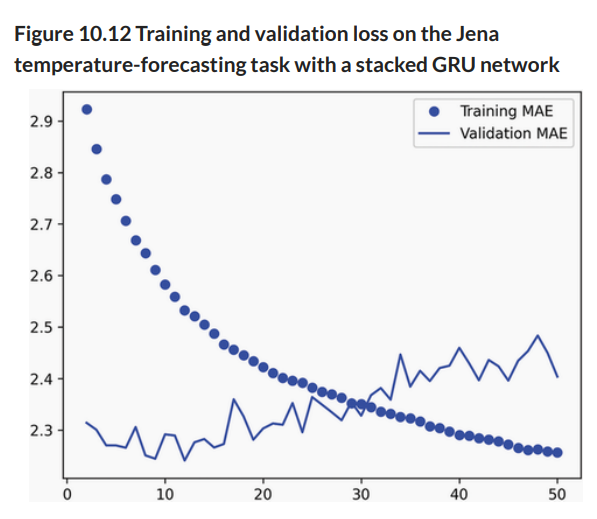

# 10.4.3 Using bidirectional RNNs

我們將在本節中看到的最後一種技術是雙向 RNN。<br>雙向 RNN 是一種常見的 RNN 變體，在某些任務上可以提供比常規 RNN 更高的性能。<br>它經常用於自然語言處理——你可以稱它為自然語言處理深度學習的瑞士軍刀。<br>
RNN 明顯依賴於順序：它們按順序處理輸入序列的時間步長，並且打亂或反轉時間步長可以完全改變 RNN 從序列中提取的表示。<br>這正是它們在順序有意義的問題上表現出色的原因，例如溫度預報問題。<br>雙向 RNN 利用了 RNN 的順序敏感性：它使用兩個常規 RNN，例如您已經熟悉的 GRU 和 LSTM 層，每個都在一個方向（按時間順序和反時間順序）處理輸入序列，然後合併它們 交涉。<br>通過雙向處理序列，雙向 RNN 可以捕獲單向 RNN 可能忽略的模式。<br>

值得注意的是，本節中的 RNN 層按時間順序處理序列（首先是較舊的時間步長）這一事實可能是一個武斷的決定。<br>至少，這是我們迄今為止沒有嘗試質疑的決定。<br>例如，如果 RNN 按反時間順序處理輸入序列（首先使用較新的時間步長），它們是否會表現得足夠好？<br>
讓我們試試這個，看看會發生什麼。<br>您需要做的就是編寫數據生成器的變體，其中輸入序列沿時間維度恢復（將最後一行替換為 yield samples[:, ::-1, :], targets ）。<br>訓練您在本節第一個實驗中使用的相同的基於 LSTM 的模型，您將得到如圖 10.13 所示的結果。<br>

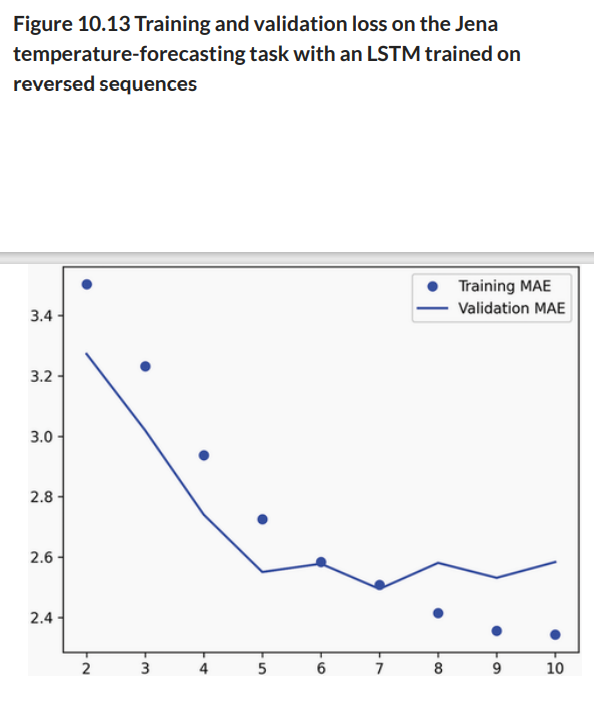

T h e r e v e r s e d o r d e r L S T M s t r o n g l y u nde r p e r f o r m s e v e n t h e c o m m o n s e n s e b a s e l i n e , i n d i c a t i n g t h a t i n t h i s c a s e , c h r o n o l o g i c a l p r o c e s s i n g i s i m p o r t a n t t o t h e s u c c e s s o f t h e a p p r o a c h .
T h i s m a k e s p e r f e c t s e n s e : t h e u nde r l y i n g L S T M l a y e r w i l l t y p i c a l l y b e b e t t e r a t r e m e m b e r i n g t h e r e c e n t p a s t t h a n t h e 72/80 distant past, and naturally the more recent weather data points are more predictive than older data points for the problem (that’s what makes the common-sense baseline fairly strong). 因此，層的時間順序版本必然優於倒序版本。

然而，對於包括自然語言在內的許多其他問題而言，情況並非如此：直覺上，單詞在理解句子中的重要性通常並不取決於它在句子中的位置。<br>在文本數據上，倒序處理與按時間順序處理一樣有效——你可以倒著閱讀文本（試試吧！）。 雖然詞序對理解語言很重要，但你使用哪種順序並不重要。<br>
重要的是，在反向序列上訓練的 RNN 將學習到與在原始序列上訓練的不同的表示，就像如果時間在現實世界中倒流你會有不同的心智模型——如果你過著你在第一天死去的生活並且出生在你的最後一天。br<>在機器學習中，不同但有用的表示總是值得利用，它們越不同越好：它們提供了一個新的角度來查看您的數據，捕獲其他人遺漏的數據方面方法，因此它們可以幫助提高任務的性能。 這就是集成背後的直覺，我們將在第 13 章探討這個概念。<br>

雙向 RNN 利用這個想法來改進按時間順序排列的 RNN 的性能。 它以兩種方式查看其輸入序列（見圖 10.14），獲得可能更豐富的表示並捕獲單獨按時間順序版本可能遺漏的模式。<br>

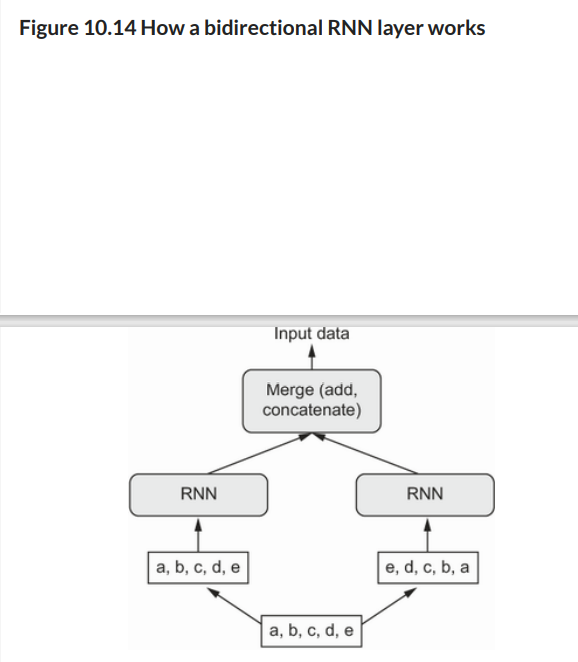

要在 Keras 中實例化雙向 RNN，您可以使用雙向層，它將循環層實例作為其第一個參數。<br>
雙向創建此循環層的第二個單獨實例，並使用一個實例按時間順序處理輸入序列，另一個實例按相反順序處理輸入序列。<br>
您可以在我們的溫度預報任務中嘗試使用它。<br>

Listing 10.24 Training and evaluating a bidirectional LSTM

In [9]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

NameError: ignored

你會發現它的表現不如普通的 LSTM 層。<br>
原因很容易理解：所有預測能力都必須來自網絡的按時間順序排列的那一半，因為眾所周知，反時間順序的那一半在這項任務上表現不佳（同樣，因為最近的過去比遙遠的過去重要得多，在這個 案子）。<br>
與此同時，反時間序列的存在使網絡的容量翻了一番，並導致它更早地開始過度擬合。<br>

然而，雙向 RNN 非常適合文本數據或任何其他類型的數據，其中順序很重要，但您使用哪種順序並不重要。 事實上，在 2016 年的一段時間裡，雙向 LSTM 被認為是許多自然語言處理任務的最先進技術（在 Transformer 架構興起之前，您將在下一章中了解它）

10.4.4 更進一步 為了提高溫度預測問題的性能，你可以嘗試許多其他的事情：調整堆疊設置中每個循環層的單元數量，以及丟失的數量。<br>
當前的選擇在很大程度上是任意的，因此可能不是最優的。<br>
調整 RMSprop 優化器使用的學習率，或嘗試不同的優化器。
嘗試使用一堆 Dense 層作為循環層頂部的回歸器，而不是單個 Dense 層。
77/80 改進模型的輸入：嘗試使用更長或更短的序列或不同的採樣率，或者開始進行特徵工程。<br>
一如既往，深度學習與其說是一門科學，不如說是一門藝術。<br>
我們可以提供指導方針，建議在給定問題上什麼可能有效或無效，但最終，每個數據集都是獨一無二的； 你必鬚根據經驗評估不同的策略。<br>
目前還沒有理論可以提前準確地告訴你應該怎麼做才能以最佳方式解決問題。<br>
你必須迭代。<br>
根據我的經驗，將無學習基線提高約 10% 可能是您可以使用此數據集做的最好的事情。<br>
這不是很好，但這些結果是有道理的：如果您可以訪問來自不同位置的廣泛網格的數據，那麼近期天氣是高度可預測的，但如果您只有一個位置的測量值，則不太可預測。<br>
您所在位置的天氣變化取決於周圍地區當前的天氣模式。<br>

MARKETS AND MACHINE LEARNING


一些讀者肯定想採用我在這裡介紹的技術，並在預測股票市場證券未來價格（或貨幣匯率等）的問題上進行嘗試。 然而，市場具有與天氣模式等自然現象截然不同的統計特徵。 就市場而言，過去的表現並不能很好地預測未來的回報——看後視鏡是一種糟糕的駕駛方式。<br>
另一方面，機器學習適用於過去可以很好地預測未來的數據集，例如天氣、電力消耗或商店的客流量。<br>
永遠記住，所有交易從根本上講都是信息套利：通過利用其他市場參與者所缺少的數據或見解來獲得優勢。<br>
試圖使用眾所周知的機器學習技術和公開可用的數據來打敗市場實際上是一條死胡同，因為與其他人相比，你沒有任何信息優勢。 您很可能會浪費時間和資源，卻一事無成。

Summary

正如您在第 5 章中首次了解到的那樣，在處理一個新問題時，最好先為您選擇的指標建立常識基線。<br>如果您沒有要超越的基線，就無法判斷自己是否取得了真正的進步。<br>
在昂貴的模型之前嘗試簡單的模型，以確保額外的費用是合理的。<br> 有時，一個簡單的模型會成為您的最佳選擇。<br>
當您擁有排序很重要的數據時，特別是對於時間序列數據，循環網絡非常適合併且很容易勝過首先展平時間數據的模型。 <br>Keras 中可用的兩個基本 RNN 層是 LSTM 層和 GRU 層。<br>
要將 dropout 與循環網絡一起使用，您應該使用時間常數 dropout 掩碼和循環 dropout 掩碼。 <br>這些內置於 Keras 循環層中，因此您所要做的就是使用循環層的 recurrent_dropout 參數。<br>
堆疊的 RNN 比單個 RNN 層提供更多的表示能力。<br> 它們也貴得多，因此並不總是值得的。<br> 儘管它們在復雜問題（如機器翻譯）上提供了明顯的收益，但它們可能並不總是與更小、更簡單的問題相關。<br>